In [3]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import glob
import pandas as pd
import os

In [6]:
def loca2_processing(scenario, variable):
    
    base_directory = "/data/keeling/a/cristi/a/esm_data/downscaled_data/LOCA2/"
    models = next(os.walk(base_directory))[1]
    #time index to assign model times to
    new_time_index=pd.date_range(start='2015-01-01',freq='D',periods=31411)

    list_dataset_model = []
    for model in models:
        print(model)
        directory = base_directory +  model + '/' + scenario + '/'
        all_files = glob.glob(directory + '/*')
        
        ens_mem = []
        for file in all_files:
            ens_mem.append(file.split('.')[3])
        if not ens_mem:
            continue
        list_dataset_mem = []
        for mem in list(set(ens_mem)):
            files_mem = glob.glob(directory + '/' + variable + '.' + model + '.' + scenario + '.' + mem + '.' + '*')
            dataset_mem = xr.open_mfdataset(files_mem,combine="by_coords",use_cftime=True)  
            dataset_mem = dataset_mem.assign(time=new_time_index).isel(time=slice(0,365*30))
            dataset_mem['ens_mem'] = mem
            list_dataset_mem.append(dataset_mem)
        if len(list_dataset_mem) == 1:
            #dataset_model = list_dataset_mem[0].assign_coords({'ens_mem':list(set(ens_mem))[0]})
            dataset_model = list_dataset_mem[0]
        else:
            dataset_model = xr.concat(list_dataset_mem, dim='ens_mem', coords='minimal', compat='override')
            dataset_model = dataset_model.mean('ens_mem')
        dataset_model['name'] = model
        dataset_model.load()
        list_dataset_model.append(dataset_model)
    dataset = xr.concat(list_dataset_model, dim='name', coords='minimal', compat='override')
    dataset = dataset.sel(lat=slice(36.9,42.6)).sel(lon=slice(268.4,272.5))
    return dataset

In [7]:
dataset = loca2_processing('ssp370', 'pr')
dataset

ACCESS-CM2
ACCESS-ESM1-5
AWI-CM-1-1-MR
BCC-CSM2-MR
CESM2-LENS
CNRM-CM6-1
CNRM-CM6-1-HR
CNRM-ESM2-1
CanESM5
EC-Earth3
EC-Earth3-Veg
FGOALS-g3
GFDL-CM4
GFDL-ESM4
HadGEM3-GC31-LL
HadGEM3-GC31-MM
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
KACE-1-0-G
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NorESM2-LM
NorESM2-MM
TaiESM1


<xarray.Dataset>
Dimensions:  (lon: 66, lat: 92, time: 10950, name: 23)
Coordinates:
  * lon      (lon) float64 268.4 268.5 268.5 268.6 ... 272.3 272.3 272.4 272.5
  * lat      (lat) float64 36.91 36.97 37.03 37.09 ... 42.41 42.47 42.53 42.59
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2044-12-23
  * name     (name) <U13 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'NorESM2-MM' 'TaiESM1'
Data variables:
    pr       (name, time, lat, lon) float32 0.0 0.0 1.968e-06 ... nan nan nan

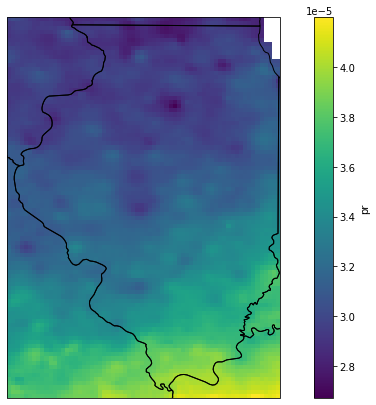

In [10]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree())
dataset.pr.mean('time').mean('name').plot()
ax.add_feature(cfeature.STATES)